# 单发多框检测SSD
在多个分辨率下的预测bounding-box并预测类别

图片 -> 基础网络块base_blk -> 多个增加通道数，但是可以使图片长宽减半的sample_down_blk
后面两步的blk都能做 类别预测 和 边界框预测

## 基础：多尺度目标检测

In [2]:
import matplotlib.pyplot as plt
import My_utils
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt

img = plt.imread('./img/catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

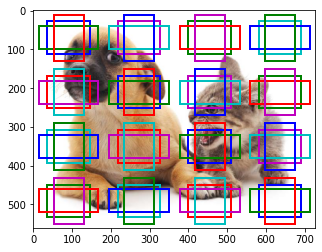

In [3]:
# 在特征图上以每个像素为中心生成不同size的锚框的函数
def display_anchors(fmap_h, fmap_w, s):
    """
    :param fmap_h: 特征图的高度，在竖直上画的框的数量
    :param fmap_w: 特征图的宽度，在水平上画的框的数量
    :param s: size的集合
    """
    My_utils.set_figsize()
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = My_utils.anchor_boxes(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    My_utils.show_bbox(plt.imshow(img).axes, anchors[0] * bbox_scale)


display_anchors(4, 4, [0.15])

## SSD的实现

In [4]:
import torch
from torch import nn
import torchvision
from torch.nn import functional as F
import matplotlib.pyplot as plt
import My_utils

In [5]:
def forward(x, block):
    return block(x)
def class_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1)
Y1 = forward(torch.zeros((2, 8, 20, 20)), class_predictor(8, 5, 10))
# 图片20像素*20像素，每个像素生成5个锚框，对十个类别进行预测，因此共20 * 20 * 5 * (10 + 1)
Y2 = forward(torch.zeros((2, 16, 10, 10)), class_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [6]:
def bounding_box_predictor(num_inputs, num_anchors):
    # 预测的是每个锚框的offset，offset是四个变量，因此输出量要*4
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)
def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [7]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )  # 不改变高宽
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels  # 下一个blk不改变channel数
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape  # 高宽减半的Conv2d

torch.Size([2, 10, 10, 10])

In [8]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i + 1]))
    return nn.Sequential(*blk)  # 3次降采样，使得长宽缩减为原来的1/8

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [9]:
# 多个尺度的特征图，完成目标检测
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveAvgPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

## 前向传播，不同于之前的图像分类

In [10]:
def blk_forward(x, blk, size, ratio, cls_predictor, bbox_predictor):
    y = blk(x)
    anchors = My_utils.anchor_boxes(y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(y)
    bbox_preds = bbox_predictor(y)
    return (y, anchors, cls_preds, bbox_preds)

In [11]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [12]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))  # 生成某种尺度的块
            setattr(self, f'cls_{i}', class_predictor(idx_to_in_channels[i], num_anchors, num_classes))  # 该种尺度的块对应的类别预测
            setattr(self, f'bbox_{i}', bounding_box_predictor(idx_to_in_channels[i], num_anchors))
        
        
    def forward(self, x):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            x, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(x, getattr(self, f'blk_{i}'), size=sizes[i], ratio=ratios[i], cls_predictor=getattr(self, f'cls_{i}'), bbox_predictor=getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes+1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [13]:
net = TinySSD(num_classes=1)
x = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(x)
print('anchors', anchors.shape)
print('cls_preds', cls_preds.shape)
print('bbox_preds', bbox_preds.shape)

anchors torch.Size([1, 5444, 4])
cls_preds torch.Size([32, 5444, 2])
bbox_preds torch.Size([32, 21776])


## 构造香蕉数据集

In [14]:
def read_banana_data(is_Train=True):
    csv_fname = os.path.join('banana-detection', 'bananas_train' if is_Train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(os.path.join('banana-detection', 'bananas_train' if is_Train else 'bananas_val', 'images', f'{img_name}')))
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256


class BananaDataset(torch.utils.data.Dataset):
    def __init__(self, is_Train):
        self.features, self.labels = read_banana_data(is_Train)
    
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])
    
    def __len__(self):
        return len(self.features)
    
    
def load_banana_data(batch_size):
    train_iter = torch.utils.data.DataLoader(BananaDataset(is_Train=True), batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananaDataset(is_Train=False), batch_size, shuffle=False)
    return train_iter, val_iter

batch_size = 32
train_iter, _ = load_banana_data(batch_size)

## 正式训练

In [15]:
device, net = My_utils.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [16]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes), cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)  # 每个batch对应一个loss
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)  # 每个batch对应一个loss
    return cls + bbox

def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

class_err 3.32e-03, bbox_mae 3.23e-03
10328.1 examples on device cuda:0


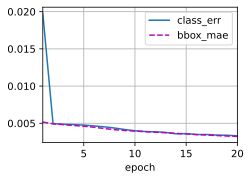

In [17]:
num_epochs, timer = 20, My_utils.Timer()
animator = My_utils.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['class_err', 'bbox_mae'])
net = net.to(device)
for epoch in range(num_epochs):
    metrics = My_utils.Accumulator(4)
    net.train()
    for features, targets in train_iter:
        timer.start()
        trainer.zero_grad()
        x, y = features.to(device), targets.to(device)
        # 生成多尺度的锚框、类型的预测和偏移量的预测
        anchors, cls_preds, bbox_preds = net(x)
        # 生成label
        bbox_labels, bbox_masks, cls_labels = My_utils.multi_box_labels(anchors, y)
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()
        metrics.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(), bbox_eval(bbox_preds, bbox_labels, bbox_masks), bbox_labels.numel())
    cls_err, bbox_mae = 1 - metrics[0] / metrics[1], metrics[2] / metrics[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class_err {cls_err:.2e}, bbox_mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples on device {str(device)}')

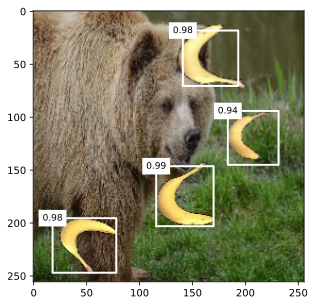

In [18]:
x = torchvision.io.read_image('./img/banana.jpg').unsqueeze(0).float()
img = x.squeeze(0).permute(1, 2, 0).long()
'''
在 PyTorch 中，使用 torchvision.io.read_image 读取图片时，返回的是一个 Tensor，其形状为 [C, H, W]，即通道数、高度和宽度。这是因为 PyTorch 主要用于深度学习，而在深度学习中，图像数据通常以通道为首的格式存储。但是，matplotlib.pyplot 的 imshow 方法期望图像的形状为 [H, W, C]，即高度、宽度和通道数。
'''

def predict(x):
    net.eval()
    anchors, cls_preds, bbox_preds = net(x.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)  # 将表示类别的class_id放在第二维，方便分离背景类和非背景类
    output = My_utils.multi_box_predictions(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]  # output 存了六个值，分别是class_id,cls_probs,以及四个坐标
    return output[0][idx]
output = predict(x)
def display(img, output, threshold):
    My_utils.set_figsize((5, 5))
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        My_utils.show_bbox(fig.axes, bbox, '%.2f' % score, 'w')
display(img, output, threshold=0.9)